In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

# Questions
- What catchment characteristics correlate with places we perform well / badly?
- Any relationship between discharge and soil moisture sims?

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))

In [4]:
from scripts.cell_state.normalize import normalize_cstate

# better normalize c state

if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")

### ESA CCI SM

In [5]:
from scripts.cell_state.normalize import normalize_2d_dataset

filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
if not isinstance(esa_ds, xr.Dataset):
    esa_ds = esa_ds.to_dataset()

for var in esa_ds.data_vars:
    esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=True)

Normalising each station: 100%|██████████| 670/670 [00:00<00:00, 758.64it/s]


In [6]:
esa_ds.to_netcdf(data_dir / "SOIL_MOISTURE/FINAL/esa_ds_interpolated_normalised.nc")

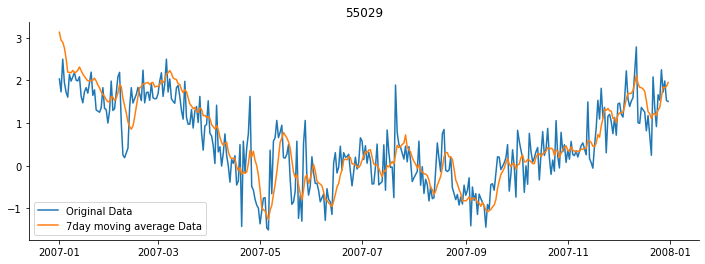

In [7]:
px = np.random.choice(esa_ds.station_id.values)
time = "2007"
f, ax = plt.subplots(figsize=(12, 4))

orig = esa_ds["sm"].sel(time=time, station_id=px)
roll = esa_ds["7_day_smooth_sm"].sel(time=time, station_id=px)
ax.plot(orig.time, orig.values, label="Original Data")
ax.plot(orig.time, roll.values, label="7day moving average Data")
ax.legend()
ax.set_title(px)

sns.despine()

# ERA5Land SM Data

In [8]:
era5filepath = (data_dir / "camels_basin_ERA5Land_sm.nc")
era5_sm = xr.open_dataset(era5filepath)

# CAMELS GB Data

In [9]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))
ds

<xarray.Dataset>
Dimensions:         (station_id: 671, time: 16436)
Coordinates:
  * station_id      (station_id) int64 1001 2001 2002 ... 102001 106001 107001
  * time            (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation   (time, station_id) float64 ...
    pet             (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    discharge_vol   (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

# Analysis

In [10]:
from scripts.cell_state.analysis import calculate_raw_correlations
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples

In [11]:
cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

# Linear Model

In [12]:
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples
from tqdm import tqdm
from scripts.cell_state.analysis import plot_weights
from sklearn.linear_model import SGDRegressor
from scripts.read_nh_results import calculate_all_error_metrics
from scripts.cell_state.timeseries_model import _round_time_to_hour
from scripts.cell_state.timeseries_model import _round_time_to_hour
from scripts.cell_state.analysis import get_model_weights, plot_weights


SEED = 100
np.random.seed(SEED)

In [13]:
train_start_date = cs.time.min().values
train_end_date = pd.to_datetime("2006-09-30")
test_start_date = pd.to_datetime("2006-10-01")
test_end_date =  cs.time.max().values

input_variables = [v for v in cs.data_vars]

# What about for camels Q?

In [14]:
Q_TARGET_VAR = "discharge_spec"


q_train_dataset = TimeSeriesDataset(
    input_data=cs.sel(time=slice(train_start_date, train_end_date)),
    target_data=ds.sel(time=slice(train_start_date, train_end_date)),
    target_variable=Q_TARGET_VAR,
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Train Samples",
)

q_test_dataset = TimeSeriesDataset(
    input_data=cs.sel(time=slice(test_start_date, test_end_date)),
    target_data=ds.sel(time=slice(test_start_date, test_end_date)),
    target_variable=Q_TARGET_VAR,
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Test Samples",
)

Creating Test Samples: 100%|██████████| 669/669 [00:13<00:00, 49.23it/s]


In [15]:
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples

q_X, q_y, q_times, q_station_ids = get_time_basin_aligned_samples(q_train_dataset)
q_X_test, q_y_test, q_times_test, q_station_ids_test = get_time_basin_aligned_samples(q_test_dataset)

Extracting Data: 100%|██████████| 8205/8205 [00:59<00:00, 137.74it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2123/2123 [00:14<00:00, 144.80it/s]

Merging and reshaping arrays


### fit and predict

In [16]:
from sklearn.linear_model import SGDRegressor


q_sgd_en = SGDRegressor(
    loss="huber",
    penalty="elasticnet",
    alpha=0.01,
    l1_ratio=0.15,            # default
    fit_intercept=True, 
    n_iter_no_change=10,
    early_stopping=True
)

q_sgd_en.fit(q_X, q_y.ravel())

SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=10,
             penalty='elasticnet')

In [17]:
q_y_hat = q_sgd_en.predict(q_X_test)

In [18]:
q_preds_sklearn = pd.DataFrame({
    "station_id": q_station_ids_test.ravel(),
    "time": q_times_test.astype("datetime64[ns]").ravel(),
    "obs": q_y_test.ravel(),
    "sim": q_y_hat.ravel(),
}).set_index(["station_id", "time"]).to_xarray()

In [19]:
if True:
    q_y_hat_train = q_sgd_en.predict(q_X)
    print("Made Predictions")
    
    q_train_preds = pd.DataFrame({
        "station_id": q_station_ids.ravel(),
        "time": q_times.astype("datetime64[ns]").ravel(),
        "obs": q_y.ravel(),
        "sim": q_y_hat_train.ravel(),
    }).set_index(["station_id", "time"]).to_xarray()

Made Predictions


### get error metrics

In [20]:
from scripts.read_nh_results import calculate_all_error_metrics

q_errors_sklearn = calculate_all_error_metrics(
    q_preds_sklearn,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "Pearson-r"],
)

q_train_errors_sklearn = calculate_all_error_metrics(
    q_train_preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "Pearson-r"],
)

Calculating Errors: 100%|██████████| 666/666 [00:10<00:00, 64.10it/s, 107001]


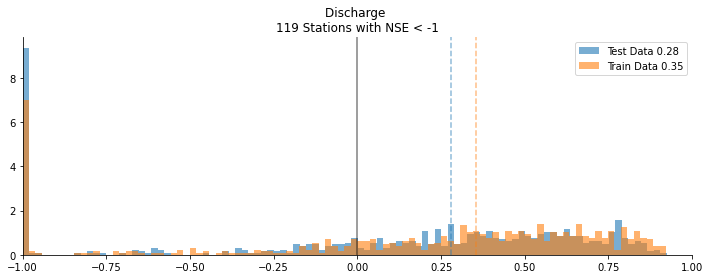

In [22]:
from scripts.cell_state.analysis import finite_flat


nse = finite_flat(q_errors_sklearn["NSE"])
nse_train = finite_flat(q_train_errors_sklearn["NSE"])

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"Test Data {nse.median().values:.2f}", alpha=0.6);
ax.axvline(nse.median(), color="C0", ls="--", alpha=0.5)

ax.hist(nse_train.where(nse_train > -1, -1), bins=100, density=True, label=f"Train Data {nse_train.median().values:.2f}", alpha=0.6);
ax.axvline(nse_train.median(), color="C1", ls="--", alpha=0.5)

ax.axvline(0, color="k", ls="-", alpha=0.5)
ax.set_title(f"Discharge \n{int((nse < -1).sum())} Stations with NSE < -1")
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

### check out results

In [23]:
# create dataframes of X/y for model
q__x_df = pd.DataFrame(
    {f"dim{i}": q_X[:, i] for i in range(q_X.shape[-1])}
)
q__df = pd.DataFrame({
    "station_id": q_station_ids.ravel(), "time": q_times.astype("datetime64[ns]").ravel(), "y": q_y.ravel(), 
})
q_analysis_df = q__df.join(q__x_df).set_index(["time", "station_id"])
q_analysis_ds = q_analysis_df.to_xarray()
q_analysis_ds["time"] = _round_time_to_hour(q_analysis_ds["time"].values)

q__x_df = pd.DataFrame(
    {f"dim{i}": q_X_test[:, i] for i in range(q_X_test.shape[-1])}
)
q__df = pd.DataFrame({
    "station_id": q_station_ids_test.ravel(), "time": q_times_test.astype("datetime64[ns]").ravel(), "y": q_y_test.ravel(), 
})
q_test_analysis_df = q__df.join(q__x_df).set_index(["time", "station_id"])
q_test_analysis_ds = q_test_analysis_df.to_xarray()

# create the xarray object
q_analysis_ds = xr.concat([q_analysis_ds, q_test_analysis_ds], dim="time")

In [24]:
px = np.random.choice(q_preds_sklearn["station_id"].values)
px = 53013
time_str = "2007"

# select station id, time
data = q_preds_sklearn.sel(station_id=px, time=time_str).to_dataframe()

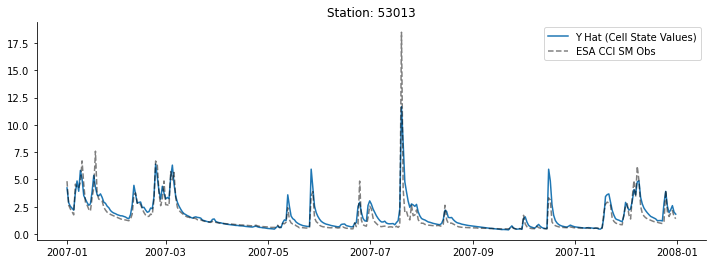

In [25]:
f, ax = plt.subplots(figsize=(12, 4))
ax.plot(data.index, data["sim"], label="Y Hat (Cell State Values)")
ax.plot(data.index, data["obs"], alpha=0.5, color="k", ls="--", label="ESA CCI SM Obs")
ax.set_title(f"Station: {px}")
ax.legend()
sns.despine()

<AxesSubplot:>

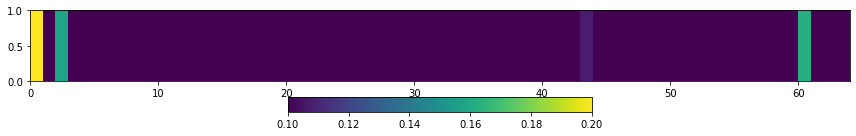

In [26]:
q_w, q_b = get_model_weights(q_sgd_en)

plot_weights(np.abs(q_w), kwargs={"vmin": 0.1, "vmax": 0.2})

In [27]:
max_idx = np.argmax(np.abs(q_w))
n = 3
largest_n = np.abs(q_w).argsort()[-n:][::-1]
feature = f"dim{max_idx}"

features = [f"dim{idx}" for idx in largest_n]

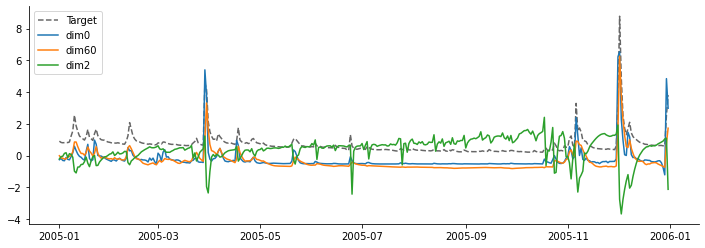

In [28]:
time = "2005"
px = 53013
# px = np.random.choice(analysis_ds.station_id.values)

f, ax = plt.subplots(figsize=(12, 4))
data = q_analysis_ds.sel(station_id=px, time=time).to_dataframe()
ax.plot(data.index, data["y"], label="Target", color="k", ls="--", alpha=0.6)
ax.legend(loc="upper right")

# ax2 = ax.twinx()
for ix, feature in enumerate(features):  # features  ["dim20"]
    ax.plot(data.index, data[feature], label=f"{feature}", color=f"C{ix}")
    ax.legend(loc="upper left")

sns.despine()

# Which stations have the best soil moisture performance?

In [29]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [30]:
points = load_latlon_points(Path("/home/tommy/spatio_temporal/data"))
gdf = gpd.GeoDataFrame(q_errors_sklearn["NSE"].to_dataframe().join(points))

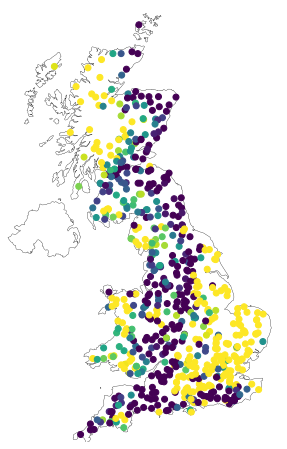

In [33]:
ax = initialise_gb_spatial_plot()
cbar = False
vmax = 0.5
vmin = 0.0

if cbar:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    gdf.plot("NSE", ax=ax, vmin=vmin, vmax=vmax, cmap="viridis_r", cax=cax, legend=True);
else:
    gdf.plot("NSE", ax=ax, vmin=vmin, vmax=vmax, cmap="viridis_r")